In [1]:
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
from tkinter import *
from tkinter import ttk
import time


from synt.const import *
from synt.synt import *
from synt.osc import *
from synt.function import *
from synt.envolv import *
from synt.effects import *
import os

In [2]:
'''MOSTAR ONDAS COPIANDOLAS PARA QUE NO SE ALTERE EL FRAME'''
from copy import copy
def showOsc(osc, time, chunks=False):
    _osc = copy(osc)
    signal = np.zeros(0)
    _chunks = int(time*(SRATE+CHUNK)/CHUNK)
    if chunks:
        _chunks = time
    for i in range(_chunks):
        signal = np.concatenate((signal, _osc.next()))
    plt.plot(signal)

In [3]:
'''REPRODUCTOR'''
input = None

def callback(outdata, frames, time, status):
    global input
    # print('entro')
    if input is not None:
        bloque = input.next()
        # convertimos formato (CHUNK,) a (CHUNK,1) para que adecuarlo a sounddevice
        outdata[:] = bloque.reshape(-1, 1)
    else:
        # si no hay datos, reproducimos silencio
        outdata[:] = np.zeros((CHUNK, 1))


# stream de salida con callBack
stream = sd.OutputStream(samplerate=SRATE, channels=2, callback=callback, blocksize=CHUNK)
stream.start()

In [4]:
raise Exception("Para de ejecutar!!") #(comentar para ejecutar todo de una)

Exception: Para de ejecutar!!

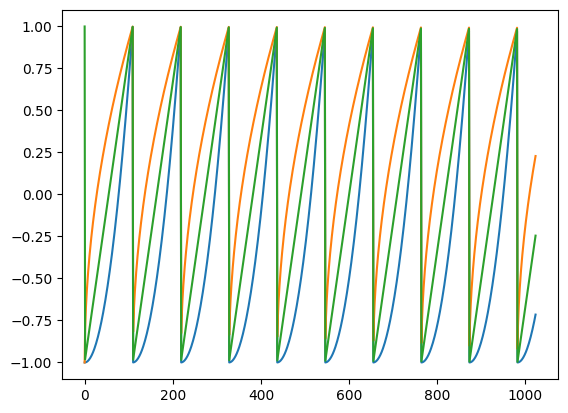

In [42]:

freq = C(440)
s1 = Rep(freq, XP(valor=freq, pow=C(2)) * C(2) - C(1))
s2 = Rep(freq, XP(valor=freq, pow=C(1/2)) * C(2) - C(1))
# s2 = Rep(C(440), XP(valor=C(440), pow=C(2)) * C(2) - C(1), phase=Sine(C(440)))
s3 = Sawtooth(freq, phase=C(np.pi/2))
showOsc(s1, 1, True)
showOsc(s2, 1, True)
showOsc(s3, 1, True)
input = s1

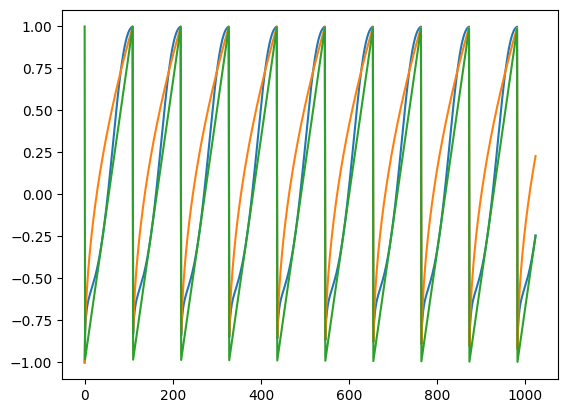

In [ ]:
freq = C(440)
s1 = Rep(freq, XP(valor=freq, pow=Sine(freq / C(1.5), min=C(0))) * C(2) - C(1)) # * C(2) - C(1) es para que vaya de -1 a 1 
s2 = Rep(freq, XP(valor=freq, pow=C(1/2)) * C(2) - C(1))
s3 = Sawtooth(freq, phase=C(np.pi/2))
showOsc(s1, 1, True)
showOsc(s2, 1, True)
# showOsc(s3, 1, True)
input = s1